In [191]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [192]:
# load data
def load_digit(file_name: str):
    digit = np.loadtxt(file_name, delimiter=',')
    return digit.reshape(-1, 28, 28)


In [193]:
digit_5 = load_digit('digit_5.csv')
digit_6 = load_digit('digit_6.csv')

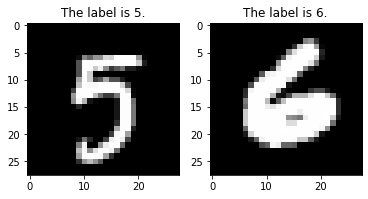

In [194]:
# visualize image
fig, axes = plt.subplots(1, 2)
axes[0].set_title("The label is 5.")
axes[0].imshow(digit_5[1], cmap='gray')
axes[1].set_title("The label is 6.")
axes[1].imshow(digit_6[1], cmap='gray')
fig.savefig("fig.png", dpi=300)

In [195]:
np.concatenate((digit_5, digit_6)).shape

(10404, 28, 28)

In [196]:
data = np.concatenate((digit_5, digit_6))
label = np.concatenate((
    np.zeros(len(digit_5)), np.ones(len(digit_6))
))

In [197]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data, label, 
                                                    random_state=2021,
                                                   test_size = 0.25)

## SVM for Classifying Digits

In [198]:
# import necessary pakages in this cell
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [224]:
# Train a linear SVM with soft margin and  Cross-validate the margin parameter.

pipeline = make_pipeline(LinearSVC())
print(pipeline.get_params())

{'memory': None, 'steps': [('linearsvc', LinearSVC())], 'verbose': False, 'linearsvc': LinearSVC(), 'linearsvc__C': 1.0, 'linearsvc__class_weight': None, 'linearsvc__dual': True, 'linearsvc__fit_intercept': True, 'linearsvc__intercept_scaling': 1, 'linearsvc__loss': 'squared_hinge', 'linearsvc__max_iter': 1000, 'linearsvc__multi_class': 'ovr', 'linearsvc__penalty': 'l2', 'linearsvc__random_state': None, 'linearsvc__tol': 0.0001, 'linearsvc__verbose': 0}


In [225]:
Cs = [0.001, 0.01, 0.1, 0.3, 0.5, 1]
hyperparameters = { 'linearsvc__C': Cs}

In [226]:
nsamples, nx, ny = train_X.shape
d2_train_X = train_X.reshape((nsamples,nx*ny))

In [227]:
from sklearn.metrics import accuracy_score
def my_scorer(y_true, y_predicted):
    error = 1-accuracy_score(y_true, y_predicted)
    return error

from sklearn.metrics import make_scorer
misclass = make_scorer(my_scorer, greater_is_better=False)

In [228]:
svm_model1 = GridSearchCV(pipeline,param_grid=hyperparameters, 
                          cv=10, return_train_score = True,
                         scoring = misclass,
                         n_jobs=-1,
                         verbose=1)

svm_model1.fit(d2_train_X, train_y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=Pipeline(steps=[('linearsvc', LinearSVC())]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [0.001, 0.01, 0.1, 0.3, 0.5, 1]},
             return_train_score=True,
             scoring=make_scorer(my_scorer, greater_is_better=False),
             verbose=1)

In [229]:
print(svm_model1.best_params_)

{'linearsvc__C': 0.01}


In [230]:
print(svm_model1.refit)

True


In [231]:
# evaluate accuracy on this cell
from sklearn.metrics import accuracy_score

nsamples, nx, ny = test_X.shape
d2_test_X = test_X.reshape((nsamples,nx*ny))

model_pred = svm_model1.predict(d2_test_X)
mis_rate = 1 - accuracy_score(test_y, model_pred)
mis_rate

0.01922337562475973

In [248]:
# source: https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search
# fucntion for plot GridSearch
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

best parameters: {'linearsvc__C': 0.01}
best score:      0.02179 (+/-0.00353)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
1,0.35314,0.012716,0.004049,0.000781,0.01,{'linearsvc__C': 0.01},-0.017926,-0.029449,-0.017926,-0.025641,...,-0.015950,-0.013812,-0.015093,-0.014666,-0.014524,-0.015805,-0.014951,-0.014951,-0.014823,0.000693
2,0.63397,0.050985,0.003661,0.000418,0.1,{'linearsvc__C': 0.1},-0.020487,-0.028169,-0.017926,-0.021795,...,-0.007975,-0.007119,-0.006835,-0.007689,-0.008116,-0.006692,-0.007404,-0.006835,-0.007362,0.000514


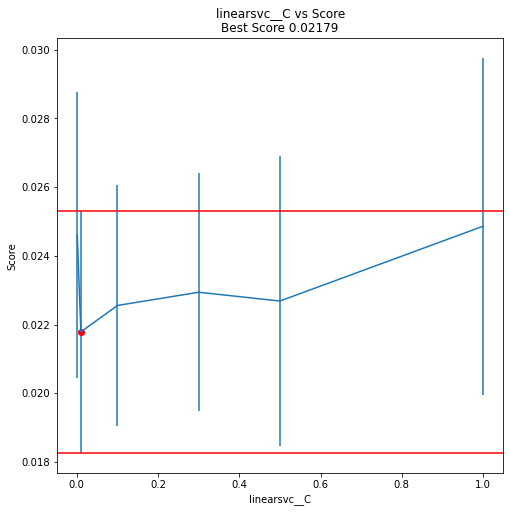

In [255]:
GridSearch_table_plot(svm_model1, "linearsvc__C", num_results = 2, 
                      negative=True, display_all_params = False)

In [233]:
# second svc model
from sklearn.svm import SVC

pipeline2 = make_pipeline(SVC(kernel='rbf'))
print(pipeline2.get_params())

{'memory': None, 'steps': [('svc', SVC())], 'verbose': False, 'svc': SVC(), 'svc__C': 1.0, 'svc__break_ties': False, 'svc__cache_size': 200, 'svc__class_weight': None, 'svc__coef0': 0.0, 'svc__decision_function_shape': 'ovr', 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'svc__max_iter': -1, 'svc__probability': False, 'svc__random_state': None, 'svc__shrinking': True, 'svc__tol': 0.001, 'svc__verbose': False}


In [234]:

Cs = [0.001, 0.01, 0.1, 0.3, 0.5]
gammas = [0.1, 1, 10, 100]
hyperparameters2 = { 'svc__C': Cs,
                  'svc__gamma': gammas}

In [235]:
svm_model2 = GridSearchCV(pipeline2,param_grid=hyperparameters2, 
                          cv=5, return_train_score = True,
                         scoring = misclass,
                         n_jobs=-1,
                         verbose=1)

svm_model2.fit(d2_train_X, train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('svc', SVC())]), n_jobs=-1,
             param_grid={'svc__C': [0.001, 0.01, 0.1, 0.3, 0.5],
                         'svc__gamma': [0.1, 1, 10, 100]},
             return_train_score=True,
             scoring=make_scorer(my_scorer, greater_is_better=False),
             verbose=1)

In [236]:
print(svm_model2.best_params_)

{'svc__C': 0.5, 'svc__gamma': 0.1}


In [237]:
print(svm_model1.refit)

True


In [238]:
# evaluate accuracy on this cell
from sklearn.metrics import accuracy_score

model_pred = svm_model2.predict(d2_test_X)
mis_rate = 1 - accuracy_score(test_y, model_pred)
mis_rate

0.0399846212995002

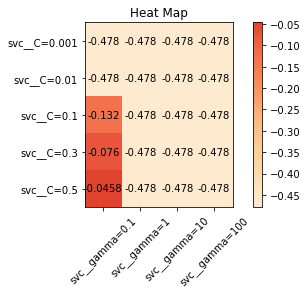

In [245]:
# heat map
from sklearn_evaluation import plot
plot.grid_search(svm_model2.cv_results_, change=("svc__C", "svc__gamma"))


import matplotlib.pyplot as plt

plt.title('Heat Map')
plt.show()

## Neural Network for Classifying Digits

In [156]:
from tensorflow import keras
from tensorflow.keras import layers

In [157]:
# reconstruct data shape
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)
train_y = keras.utils.to_categorical(train_y, num_classes=2)
test_y = keras.utils.to_categorical(test_y, num_classes=2)

input_shape = (28, 28, 1)
num_classes = 2

In [160]:
# define model structure
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

#create model (add model layers)
model1 = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(2, activation='sigmoid'),
])


#compile model using accuracy to measure model performance

opt1 = keras.optimizers.Adam(learning_rate=0.1)

model1.compile(optimizer=opt1, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [161]:
# train model
hist1 = model1.fit(train_X, train_y, 
          validation_data=(test_X, test_y),
          batch_size=128,
          epochs=10)

Epoch 1/10
61/61 [==============================] - 6s 98ms/step - loss: 21.9032 - accuracy: 0.8749 - val_loss: 0.1082 - val_accuracy: 0.9623
Epoch 2/10
61/61 [==============================] - 6s 95ms/step - loss: 0.0935 - accuracy: 0.9694 - val_loss: 0.0840 - val_accuracy: 0.9727
Epoch 3/10
61/61 [==============================] - 6s 95ms/step - loss: 0.0724 - accuracy: 0.9762 - val_loss: 0.0699 - val_accuracy: 0.9785
Epoch 4/10
61/61 [==============================] - 6s 94ms/step - loss: 0.0594 - accuracy: 0.9805 - val_loss: 0.0619 - val_accuracy: 0.9815
Epoch 5/10
61/61 [==============================] - 6s 98ms/step - loss: 0.0505 - accuracy: 0.9812 - val_loss: 0.0565 - val_accuracy: 0.9846
Epoch 6/10
61/61 [==============================] - 6s 98ms/step - loss: 0.0453 - accuracy: 0.9855 - val_loss: 0.0499 - val_accuracy: 0.9854
Epoch 7/10
61/61 [==============================] - 6s 95ms/step - loss: 0.0405 - accuracy: 0.9869 - val_loss: 0.0482 - val_accuracy: 0.9854
Epoch 8/10
6

In [168]:
# evaluate the trained model
from sklearn.metrics import accuracy_score

model_pred = model1.predict(test_X)
mis_rate = 1 - accuracy_score(test_y, (model_pred > 0.5) )
mis_rate

0.016532103037293355

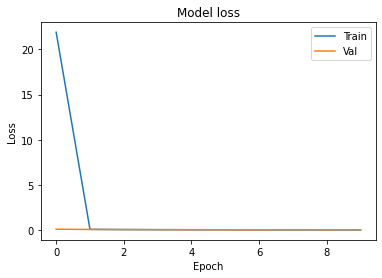

In [172]:
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [170]:
# try other learning rate
#create model (add model layers)
model2 = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(2, activation='sigmoid'),
])


#compile model using accuracy to measure model performance

opt2 = keras.optimizers.Adam(learning_rate=0.01)

model2.compile(optimizer=opt2, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
hist2 = model2.fit(train_X, train_y, 
          validation_data=(test_X, test_y),
          batch_size=128,
          epochs=10)

Epoch 1/10
61/61 [==============================] - 6s 98ms/step - loss: 0.0958 - accuracy: 0.9596 - val_loss: 0.0252 - val_accuracy: 0.9923
Epoch 2/10
61/61 [==============================] - 6s 96ms/step - loss: 0.0200 - accuracy: 0.9931 - val_loss: 0.0293 - val_accuracy: 0.9908
Epoch 3/10
61/61 [==============================] - 6s 97ms/step - loss: 0.0122 - accuracy: 0.9963 - val_loss: 0.0377 - val_accuracy: 0.9912
Epoch 4/10
61/61 [==============================] - 6s 96ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.0201 - val_accuracy: 0.9935
Epoch 5/10
61/61 [==============================] - 6s 95ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0285 - val_accuracy: 0.9931
Epoch 6/10
61/61 [==============================] - 6s 95ms/step - loss: 0.0024 - accuracy: 0.9987 - val_loss: 0.0279 - val_accuracy: 0.9938
Epoch 7/10
61/61 [==============================] - 6s 95ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.0204 - val_accuracy: 0.9950
Epoch 8/10
61

In [171]:
# evaluate the trained model
from sklearn.metrics import accuracy_score

model_pred = model2.predict(test_X)
mis_rate = 1 - accuracy_score(test_y, (model_pred > 0.5) )
mis_rate

0.0034602076124568004

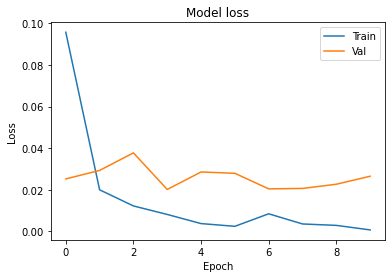

In [174]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [175]:
model3 = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(2, activation='sigmoid'),
])


#compile model using accuracy to measure model performance

opt3 = keras.optimizers.Adam(learning_rate=0.05)

model3.compile(optimizer=opt3, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
hist3 = model3.fit(train_X, train_y, 
          validation_data=(test_X, test_y),
          batch_size=128,
          epochs=10)

Epoch 1/10
61/61 [==============================] - 6s 98ms/step - loss: 2.3761 - accuracy: 0.5143 - val_loss: 0.6925 - val_accuracy: 0.5179
Epoch 2/10
61/61 [==============================] - 6s 97ms/step - loss: 0.6924 - accuracy: 0.5216 - val_loss: 0.6925 - val_accuracy: 0.5179
Epoch 3/10
61/61 [==============================] - 6s 96ms/step - loss: 0.6925 - accuracy: 0.5216 - val_loss: 0.6930 - val_accuracy: 0.5179
Epoch 4/10
61/61 [==============================] - 6s 96ms/step - loss: 0.6924 - accuracy: 0.5216 - val_loss: 0.6926 - val_accuracy: 0.5179
Epoch 5/10
61/61 [==============================] - 6s 96ms/step - loss: 0.6925 - accuracy: 0.5216 - val_loss: 0.6926 - val_accuracy: 0.5179
Epoch 6/10
61/61 [==============================] - 6s 95ms/step - loss: 0.6926 - accuracy: 0.5216 - val_loss: 0.6930 - val_accuracy: 0.5179
Epoch 7/10
61/61 [==============================] - 6s 97ms/step - loss: 0.6927 - accuracy: 0.5216 - val_loss: 0.6928 - val_accuracy: 0.5179
Epoch 8/10
61

In [176]:
# evaluate the trained model
from sklearn.metrics import accuracy_score

model_pred = model3.predict(test_X)
mis_rate = 1 - accuracy_score(test_y, (model_pred > 0.5) )
mis_rate

0.48212226066897346

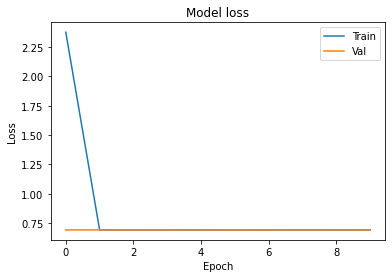

In [177]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [178]:
model4 = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(2, activation='sigmoid'),
])


#compile model using accuracy to measure model performance

opt4 = keras.optimizers.Adam(learning_rate=0.2)

model4.compile(optimizer=opt4, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
hist4 = model4.fit(train_X, train_y, 
          validation_data=(test_X, test_y),
          batch_size=128,
          epochs=10)

Epoch 1/10
61/61 [==============================] - 6s 97ms/step - loss: 91.1845 - accuracy: 0.8078 - val_loss: 0.2456 - val_accuracy: 0.9254
Epoch 2/10
61/61 [==============================] - 6s 96ms/step - loss: 0.1807 - accuracy: 0.9418 - val_loss: 0.2413 - val_accuracy: 0.8950
Epoch 3/10
61/61 [==============================] - 6s 97ms/step - loss: 0.1412 - accuracy: 0.9498 - val_loss: 0.1076 - val_accuracy: 0.9662
Epoch 4/10
61/61 [==============================] - 6s 96ms/step - loss: 0.0750 - accuracy: 0.9750 - val_loss: 0.0730 - val_accuracy: 0.9758
Epoch 5/10
61/61 [==============================] - 6s 96ms/step - loss: 0.0557 - accuracy: 0.9814 - val_loss: 0.0681 - val_accuracy: 0.9735
Epoch 6/10
61/61 [==============================] - 6s 96ms/step - loss: 0.0469 - accuracy: 0.9836 - val_loss: 0.0822 - val_accuracy: 0.9754
Epoch 7/10
61/61 [==============================] - 6s 97ms/step - loss: 0.0310 - accuracy: 0.9894 - val_loss: 0.0793 - val_accuracy: 0.9815
Epoch 8/10
6

In [179]:
# evaluate the trained model
from sklearn.metrics import accuracy_score

model_pred = model4.predict(test_X)
mis_rate = 1 - accuracy_score(test_y, (model_pred > 0.5) )
mis_rate

0.022299115724721208

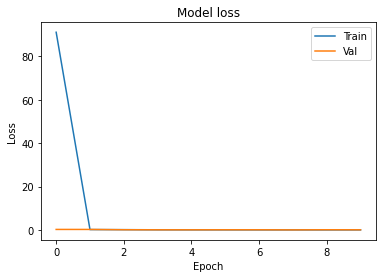

In [180]:
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [181]:
model5 = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(2, activation='sigmoid'),
])


#compile model using accuracy to measure model performance

opt5 = keras.optimizers.Adam(learning_rate=0.5)

model5.compile(optimizer=opt5, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
hist5 = model5.fit(train_X, train_y, 
          validation_data=(test_X, test_y),
          batch_size=128,
          epochs=10)

Epoch 1/10
61/61 [==============================] - 6s 96ms/step - loss: 1545.7859 - accuracy: 0.8984 - val_loss: 0.3069 - val_accuracy: 0.9200
Epoch 2/10
61/61 [==============================] - 6s 94ms/step - loss: 0.2317 - accuracy: 0.9313 - val_loss: 0.2405 - val_accuracy: 0.9369
Epoch 3/10
61/61 [==============================] - 6s 93ms/step - loss: 0.1696 - accuracy: 0.9501 - val_loss: 0.1908 - val_accuracy: 0.9508
Epoch 4/10
61/61 [==============================] - 6s 92ms/step - loss: 0.1304 - accuracy: 0.9587 - val_loss: 0.1464 - val_accuracy: 0.9585
Epoch 5/10
61/61 [==============================] - 6s 92ms/step - loss: 0.1076 - accuracy: 0.9664 - val_loss: 0.1474 - val_accuracy: 0.9631
Epoch 6/10
61/61 [==============================] - 6s 94ms/step - loss: 0.0930 - accuracy: 0.9708 - val_loss: 0.1248 - val_accuracy: 0.9685
Epoch 7/10
61/61 [==============================] - 6s 95ms/step - loss: 0.0850 - accuracy: 0.9732 - val_loss: 0.1088 - val_accuracy: 0.9677
Epoch 8/10

In [182]:
# evaluate the trained model
from sklearn.metrics import accuracy_score

model_pred = model5.predict(test_X)
mis_rate = 1 - accuracy_score(test_y, (model_pred > 0.5) )
mis_rate

0.027297193387158747

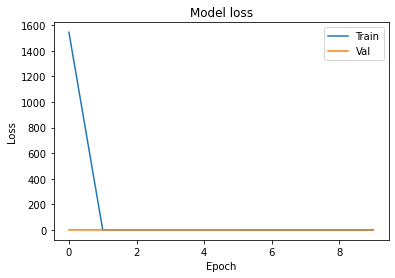

In [183]:
plt.plot(hist5.history['loss'])
plt.plot(hist5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [184]:
model6 = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    Conv2D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(2, activation='sigmoid'),
])


#compile model using accuracy to measure model performance

opt6 = keras.optimizers.Adam(learning_rate=1)

model6.compile(optimizer=opt6, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
hist6 = model6.fit(train_X, train_y, 
          validation_data=(test_X, test_y),
          batch_size=128,
          epochs=10)

Epoch 1/10
61/61 [==============================] - 6s 98ms/step - loss: 11973.0547 - accuracy: 0.8634 - val_loss: 0.7032 - val_accuracy: 0.5194
Epoch 2/10
61/61 [==============================] - 6s 96ms/step - loss: 0.7089 - accuracy: 0.4996 - val_loss: 0.7002 - val_accuracy: 0.4821
Epoch 3/10
61/61 [==============================] - 6s 96ms/step - loss: 0.6954 - accuracy: 0.5176 - val_loss: 0.7087 - val_accuracy: 0.4821
Epoch 4/10
61/61 [==============================] - 6s 96ms/step - loss: 0.7059 - accuracy: 0.5025 - val_loss: 0.6944 - val_accuracy: 0.4821
Epoch 5/10
61/61 [==============================] - 6s 96ms/step - loss: 0.6958 - accuracy: 0.5079 - val_loss: 0.6984 - val_accuracy: 0.4821
Epoch 6/10
61/61 [==============================] - 6s 96ms/step - loss: 0.6956 - accuracy: 0.5058 - val_loss: 0.6989 - val_accuracy: 0.4821
Epoch 7/10
61/61 [==============================] - 6s 94ms/step - loss: 0.6963 - accuracy: 0.5011 - val_loss: 0.6925 - val_accuracy: 0.5179
Epoch 8/1

In [185]:
# evaluate the trained model
from sklearn.metrics import accuracy_score

model_pred = model6.predict(test_X)
mis_rate = 1 - accuracy_score(test_y, (model_pred > 0.5) )
mis_rate

0.5178777393310265

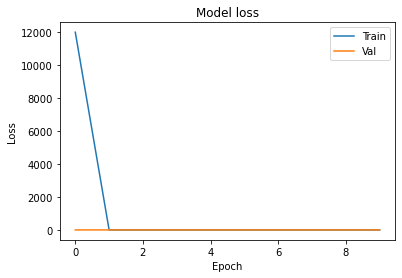

In [186]:
plt.plot(hist6.history['loss'])
plt.plot(hist6.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()